# Walmart Labs – Data Challeng

## 1. Exploratory data analysis

In [1]:
# import necessary packages 
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import chart_studio.plotly as py
import cufflinks as cf
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
cf.go_offline()

from sklearn.model_selection import train_test_split,GridSearchCV
from scipy.stats import randint
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV


In [2]:
# load data and clean

household = pd.read_csv('household_data.csv')
products = pd.read_csv('products.csv')
transaction = pd.read_csv('transaction_data.csv')

#strip space of columns 
dataframes = [household, products, transaction]
for df in dataframes:
    df.columns = [s.strip() for s in df.columns]

#strip space of rows 
for df in dataframes:
    for col in list(df.select_dtypes(['object']).columns):
        df[col] = df[col].apply(lambda x:x.strip() if type(x)==str else x)

#transfer purchase_date to datetime type   
transaction.PURCHASE_DATE = pd.to_datetime(transaction.PURCHASE_DATE)
transaction.drop(columns='Unnamed: 0',inplace=True)

### 1.1 Explore Household Data

In [3]:
print(household.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 9 columns):
HSHD_NUM            100 non-null int64
Loyalty_flag        100 non-null object
AGE_RANGE           89 non-null object
MARITAL             89 non-null object
INCOME_RANGE        89 non-null object
HOMEOWNER           89 non-null object
HSHD_COMPOSITION    89 non-null object
HH_SIZE             89 non-null object
CHILDREN            89 non-null object
dtypes: int64(1), object(8)
memory usage: 7.2+ KB
None


In [4]:
print(household['CHILDREN'].value_counts())
print('\n')
print(household['HH_SIZE'].value_counts())

NOT AVAILABLE    43
1                23
3+               16
2                 7
Name: CHILDREN, dtype: int64


3     24
1     23
2     22
5+    16
4      4
Name: HH_SIZE, dtype: int64


### 1.2 Explore Product Data

In [5]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151141 entries, 0 to 151140
Data columns (total 5 columns):
PRODUCT_NUM    151141 non-null int64
DEPARTMENT     151141 non-null object
COMMODITY      151141 non-null object
BRAND_TY       151141 non-null object
NA             151141 non-null object
dtypes: int64(1), object(4)
memory usage: 5.8+ MB


In [6]:
print(products['BRAND_TY'].value_counts())

NATIONAL    130225
PRIVATE      20916
Name: BRAND_TY, dtype: int64


In [7]:
print(products['NA'].value_counts())

N    143982
Y      7159
Name: NA, dtype: int64


In [8]:
products['COMMODITY'].value_counts()

GROCERY STAPLE           21419
GIFT                     14429
HOUSEHOLD                14224
CLOTHING                 11055
PERSONAL CARE             7976
PRODUCE                   6382
FROZEN FOOD               5515
ALCOHOL                   5474
DAIRY                     5157
IN STORE FOOD SERVICE     4632
BAKERY                    4553
COSMETICS                 4405
BEVERAGE - NON WATER      4292
MISC                      3845
PET                       3073
MEDICATION                2775
FLORAL                    2629
TOYS                      2561
INTERNATIONAL FOOD        2561
BABY                      2526
HOLIDAY                   2439
DRY GOODS                 1708
SEAFOOD                   1608
DELI                      1447
MEAT - OTHER              1278
MEAT - BEEF               1265
OUTDOOR                   1250
CANNED GOODS              1222
SEASONAL PRODUCTS         1168
BULK PRODUCTS             1134
SPECIALTY FOOD            1121
MEAT - PORK                948
ELECTRON

In [9]:
# strip subtype for simplicity 
products['COMMODITY']=products['COMMODITY'].apply(lambda x:x.split('-')[0])
products['COMMODITY'].value_counts()

GROCERY STAPLE           21419
GIFT                     14429
HOUSEHOLD                14224
CLOTHING                 11055
PERSONAL CARE             7976
PRODUCE                   6382
FROZEN FOOD               5515
ALCOHOL                   5474
MEAT                      5224
DAIRY                     5157
BEVERAGE                  5083
IN STORE FOOD SERVICE     4632
BAKERY                    4553
COSMETICS                 4405
MISC                      3845
PET                       3073
MEDICATION                2775
FLORAL                    2629
TOYS                      2561
INTERNATIONAL FOOD        2561
BABY                      2526
HOLIDAY                   2439
DRY GOODS                 1708
SEAFOOD                   1608
DELI                      1447
OUTDOOR                   1250
CANNED GOODS              1222
SEASONAL PRODUCTS         1168
BULK PRODUCTS             1134
SPECIALTY FOOD            1121
ELECTRONICS                875
TOBACCO PRODUCTS           720
AUTO    

### 1.3 Explore Transaction Data

#### 1.3.1 Data Distribution

In [10]:
transaction.describe()

,BASKET_NUM,HSHD_NUM,PRODUCT_NUM,SPEND_AMOUNT,UNITS,WEEK_NUM,YEAR
count,166136.000000,166136.000000,1.661360e+05,166136.000000,166136.000000,166136.000000,166136.000000
mean,487193.193805,41.686149,2.340603e+06,3.648166,1.265457,53.003744,2016.507927
std,293021.486129,27.857425,2.411682e+06,3.843210,1.125134,30.017231,0.499939
min,33.000000,1.000000,1.400000e+01,-13.600000,-10.000000,1.000000,2016.000000
25%,225633.000000,19.000000,1.029300e+05,1.720000,1.000000,27.000000,2016.000000
50%,488048.000000,38.000000,9.589590e+05,2.790000,1.000000,53.000000,2017.000000
75%,741262.000000,63.000000,5.055777e+06,4.160000,1.000000,79.000000,2017.000000
max,999899.000000,100.000000,6.796161e+06,210.000000,192.000000,104.000000,2017.000000


* UNITS and SPEND_AMOUNT are highly screwed 

In [11]:
transaction.sort_values('UNITS',ascending=False).head(10)

,BASKET_NUM,HSHD_NUM,PURCHASE_DATE,PRODUCT_NUM,SPEND_AMOUNT,UNITS,STORE_REGION,WEEK_NUM,YEAR
124755,114792,63,2016-03-24,5184653,190.08,192,EAST,12,2016
121803,114792,63,2016-03-24,5536877,54.00,108,EAST,12,2016
123521,791837,63,2017-07-12,86471,210.00,84,EAST,80,2017
122513,791838,63,2017-07-12,86471,210.00,84,EAST,80,2017
122507,791836,63,2017-07-12,86471,210.00,84,EAST,80,2017
121163,143727,63,2016-04-13,8625,26.00,78,EAST,15,2016
121000,134789,63,2016-04-06,8515,26.00,78,EAST,14,2016
123666,160398,63,2016-04-26,8625,26.00,78,EAST,17,2016
122377,71643,63,2016-02-24,8629,25.74,78,EAST,8,2016
123760,101980,63,2016-03-16,8515,25.74,78,EAST,11,2016


* Customer with HSHD_NUM=63 bought huge units one time

####  1.3.2 Transaction in Different Regions

In [12]:
def draw_pie(df,group_metric):
    subdf = df.groupby(group_metric).agg({'BASKET_NUM': pd.Series.nunique,'SPEND_AMOUNT':sum})
    fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])
    fig.add_trace(go.Pie(labels=subdf.index.unique(), values=subdf['BASKET_NUM'], name="Number of Orders"),
                  1, 1)
    fig.add_trace(go.Pie(labels=subdf.index.unique(), values=subdf['SPEND_AMOUNT'], name="Total Value"),
                  1, 2)
    
    # Use `hole` to create a donut-like pie chart
    fig.update_traces(hole=.4, hoverinfo="label+percent+name")
    
    fig.update_layout(
        title_text=f"Transaction Distribution in {group_metric}",
        # Add annotations in the center of the donut pies.
        annotations=[dict(text="Number of Orders", x=0.18, y=0.5, font_size=12, showarrow=False),
                     dict(text="Total Value", x=0.82, y=0.5, font_size=12, showarrow=False)])
    
    fig.show()

In [13]:
draw_pie(transaction,'STORE_REGION')

* Majority part of transactions happens in east 

#### 1.3.2 Transaction Distribution in Products Type

In [14]:
prod_trans = pd.merge(products,transaction, on='PRODUCT_NUM',how='right')


In [15]:
draw_pie(prod_trans,'BRAND_TY')

In [16]:
draw_pie(prod_trans,'DEPARTMENT')

* Food department takes part of the majority of transactions 

In [17]:
# further dive into the food 
draw_pie(prod_trans,'COMMODITY')

* Grocery staple is the most often bought commodity type
* We can use 'other' to denote those fewer bought categories

In [18]:
order_percent = prod_trans.groupby('COMMODITY')['BASKET_NUM'].apply(pd.Series.nunique)/prod_trans['BASKET_NUM'].nunique()
replace_dict={}
for key,value in order_percent.to_dict().items():
    if value<0.02:
        replace_dict[key]='OTHER'
prod_trans['COMMODITY']=prod_trans['COMMODITY'].replace(replace_dict)

#### 1.4 Analysis Over Time

<h6> Department

In [19]:
prod_trans['MONTH_YEAR'] = prod_trans['PURCHASE_DATE'].apply(lambda x: x.strftime('%Y-%m'))
prod_trans['MONTH']=prod_trans['PURCHASE_DATE'].apply(lambda x: x.strftime('%m'))
groupd = prod_trans.groupby(['MONTH','YEAR','DEPARTMENT']).agg({'BASKET_NUM':pd.Series.nunique,'SPEND_AMOUNT':sum})
groupd = groupd.reset_index()

fig = px.line(groupd, x="MONTH", y="SPEND_AMOUNT", color="YEAR", #barmode="stack",
             facet_row="DEPARTMENT",width=1000,height=800)
fig.show()

* There is no significant increase or decrease trend of the revenue over time. 
 - Therefore, we can suspect that no strong competitors or events appeared during 2016-2017
* Customers's behaviors are seasonal

<h6> Brand Type

In [55]:
groupd = prod_trans.groupby(['MONTH','YEAR','BRAND_TY']).agg({'BASKET_NUM':pd.Series.nunique,'SPEND_AMOUNT':sum})
groupd = groupd.reset_index()

fig = px.line(groupd, x="MONTH", y="SPEND_AMOUNT", color="YEAR", #barmode="stack",
             facet_row="BRAND_TY",width=800,height=400)
fig.show()

#### 1.5 Cohort Analysis

In [20]:
# get first order date
customer_data= pd.DataFrame(transaction.groupby('HSHD_NUM')['PURCHASE_DATE'].min())
customer_data.columns=['customer_first_order']

#combine table
cohort_df = pd.merge(prod_trans,customer_data.reset_index(),on='HSHD_NUM')

In [21]:
def _generate_cohorts(dataset, metric):
    cohorts = dataset.groupby(['cohort','order_period']).agg({
        'HSHD_NUM': pd.Series.nunique,
        'BASKET_NUM':pd.Series.nunique,
        'UNITS':sum,
        'SPEND_AMOUNT':sum,
    })
    cohorts.columns = ['number_of_customers','number_of_orders','number_of_items_bought','total_order_value']   
    cohorts['avg_customer_bought_items']=cohorts['number_of_items_bought']/cohorts['number_of_customers']    
    cohorts['avg_customer_spend_value']=cohorts['total_order_value']/cohorts['number_of_customers']  
    cohorts = cohorts[metric].unstack(0)   
    return cohorts

In [22]:
def generate_cohort_analysis(df, metric, product_depart='all', period_agg='monthly', fig=True, size=10, save_fig=False):
    """
    For metric use 'number_of_customers' 'number_of_orders', 'number_of_items_bought' , 
        'total_order_value', 'avg_customer_bought_items' or 'avg_customer_spend_value'
    
    For product_depart use 'all' or specific customer_type ['NON-FOOD','FOOD','PHARMA']
    no_fig controlls the output of a figure, by default True (i.e. no figure)
    """

    dataset = df.copy()
    
    if product_depart != 'all':
        dataset = df[df.DEPARTMENT == product_depart].copy()
    
    #dataset = dataset[dataset.HSHD_NUM!=63]
    
    # format dates (i.e. map customers into their cohort and orders into the respective order period)
    if period_agg=='quarterly':
        dataset['cohort'] = dataset['customer_first_order'].apply(lambda x: fortmat_quarter(x))
        dataset['order_period'] = dataset['PURCHASE_DATE'].apply(lambda x: fortmat_quarter(x))
    elif period_agg=='monthly':
        dataset['cohort'] = dataset['customer_first_order'].apply(lambda x: x.strftime('%Y-%m'))
        dataset['order_period'] = dataset['MONTH_YEAR']
    elif period_agg=='weekly':
        dataset['cohort']=dataset[dataset['type_of_order']=='first'].WEEK_NUM.mean()
        dataset['order_period']= dataset['WEEK_NUM']
    else:
        raise NotImplementedError(f'period_agg: {period_agg} is not implemented')
        
    # generate cohorts
    cohorts = _generate_cohorts(dataset,metric)

    # generate new accounts data
    cohort_group_size = dataset.groupby('cohort').agg({'HSHD_NUM': pd.Series.nunique})
    new_accs = cohort_group_size.reset_index()
    new_accs.columns = ['cohort', 'New Accounts']

    # generate repeat data
    #repeat_perc, selection = _generate_repeat_percentages(dataset,metric)

    # returns the data and does not plot anything
    if not fig:
        return (cohorts.T.join(new_accs.set_index('cohort')).fillna(0))
    
    #### Plot the Data ####
    # create the figures grid
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), gridspec_kw={'width_ratios': (2, 14)})
    sns.despine(left=True, bottom=True, right=True)
    # plot new accounts
    Accounts = sns.barplot(x="New Accounts", y='cohort', data=new_accs, palette="GnBu_d", ax=ax1)

    # plot retention matrix
    Heatmap = sns.heatmap(cohorts.T,
                          cmap=sns.mpl_palette("GnBu_d"),
                          annot=True,
                          fmt=".0f",
                          annot_kws={"size": size},
                          cbar=True,
                          yticklabels=False,
                          ax=ax2)

    title = 'Retention Matrix for "{}" - for Product Type "{}"'.format(metric, product_depart)
    Heatmap.set_title(title)
    Heatmap.yaxis.get_label().set_visible(False)
    Heatmap.set_xlabel('order_period')

    # final layout touches

    plt.tight_layout()

    # saves the figure
    if save_fig:
        fig = Heatmap.get_figure()
        fig.savefig(metric+'RetentionMatrix'+product_depart+'.png', bbox_inches='tight', dpi=600)


<h5> Customer Retention

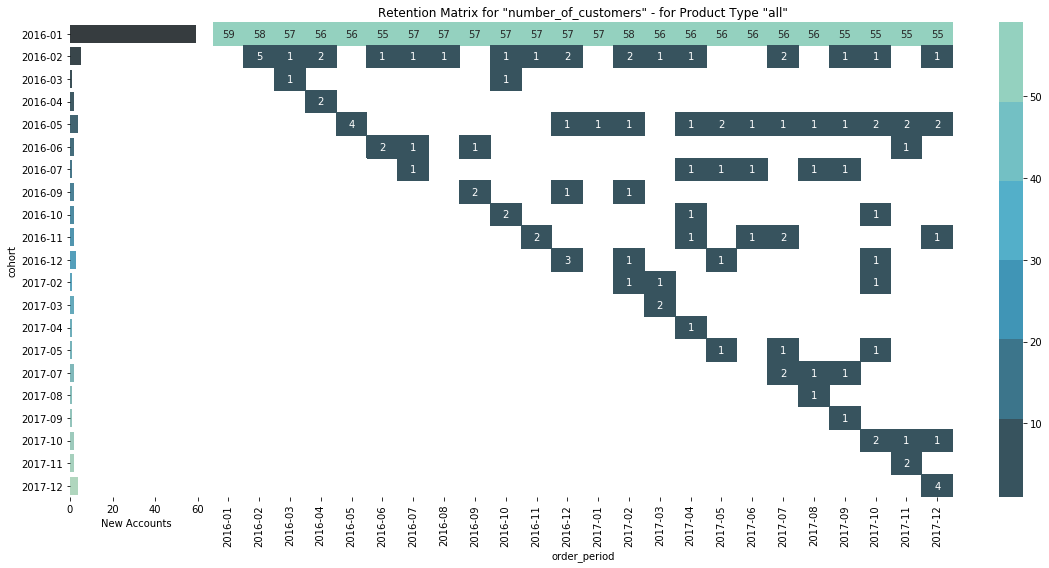

In [23]:
generate_cohort_analysis(df=cohort_df ,period_agg='monthly', metric='number_of_customers',product_depart='all')

* Half of customers are gained at or before Jan, 2016
* Almost all these customers have been with this mart for a long time.

<h5> Are customers spend more or less ?

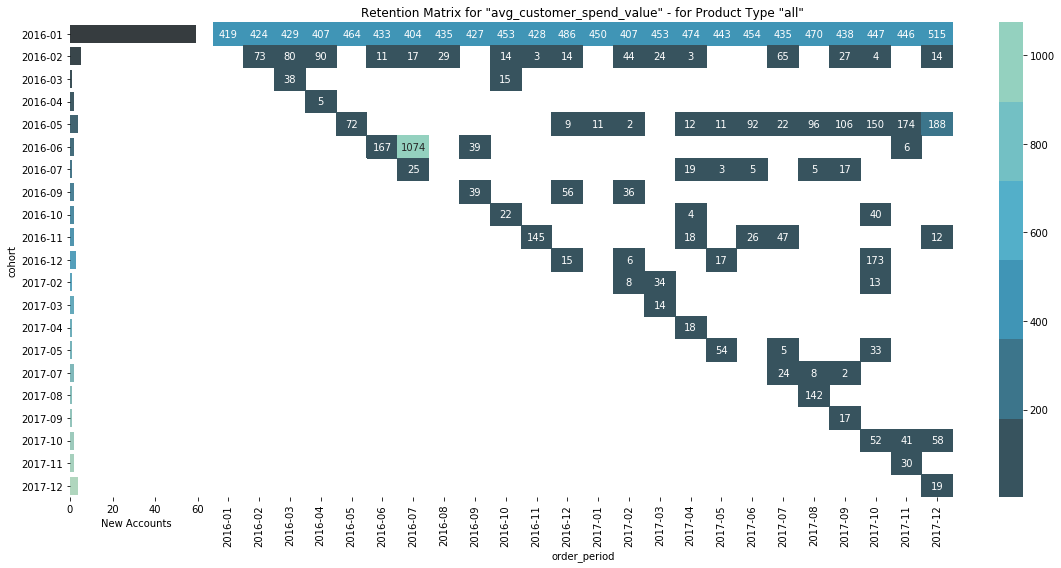

In [24]:
generate_cohort_analysis(df=cohort_df,period_agg='monthly', metric='avg_customer_spend_value',product_depart='all')

* The average value spend by each customer has a increase trend overall
 - This might due to demographic factors (i.e. the increasement of price) 
 - Inspect the average units customer bought 

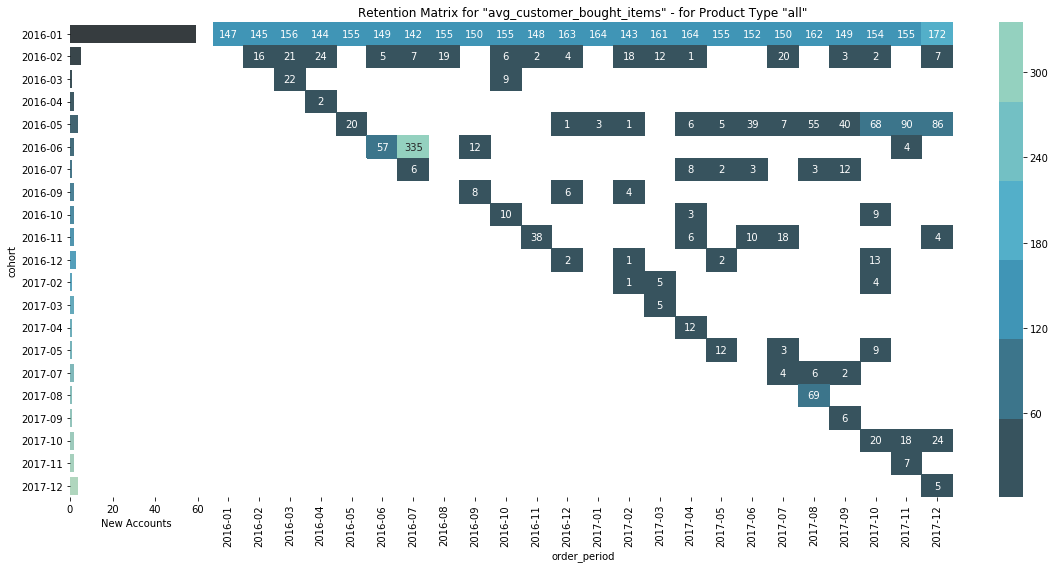

In [25]:
generate_cohort_analysis(df=cohort_df,period_agg='monthly', metric='avg_customer_bought_items',product_depart='all')

* The retention matrix for average customer bought items is consistent with average value a customer spend. 
* Hence we can include that overall, customer turns to spend more on this mart. 

<h6> Further dive with different categories

In [26]:
#extra integer value from data
def get_date_int(df, column): 
    year = df[column].dt.year 
    month = df[column].dt.month 
    day = df[column].dt.day 
    return year, month, day

In [27]:
def get_matrix_df(dataset,groupmetric1,groupmetric2):
    df = dataset.groupby([groupmetric1,groupmetric2]).agg({
        'HSHD_NUM': pd.Series.nunique,
        'BASKET_NUM':pd.Series.nunique,
        'UNITS':sum,
        'SPEND_AMOUNT':sum,
    })

    df.columns = ['number_of_customers','number_of_orders','number_of_items_bought','total_order_value'] 
    df = df.reset_index()
    df['avg_customer_bought_items']=df['number_of_items_bought']/df['number_of_customers']    
    df['avg_customer_spend_value']=df['total_order_value']/df['number_of_customers']  
    return df 

In [28]:
#assign time offset value
invoice_year, invoice_month, _ = get_date_int(cohort_df, 'PURCHASE_DATE') 
cohort_year, cohort_month, _ = get_date_int(cohort_df, 'customer_first_order')
years_diff = invoice_year - cohort_year 
months_diff = invoice_month - cohort_month
cohort_df['CohortIndex'] = years_diff * 12 + months_diff + 1 

In [29]:
#calculate metric against cohortindex and product department
coh_dep = get_matrix_df(cohort_df,'CohortIndex','DEPARTMENT')

In [64]:

fig = make_subplots(rows=3, cols=1,subplot_titles=("FOOD","NON FOOD", "PHARAM"))

fig.append_trace(go.Scatter(
    x=coh_dep[coh_dep['DEPARTMENT']=='FOOD']['CohortIndex'],
    y=coh_dep[coh_dep['DEPARTMENT']=='FOOD']['avg_customer_spend_value'],name='food'
), row=1, col=1)

fig.append_trace(go.Scatter(
    x=coh_dep[coh_dep['DEPARTMENT']=='NON-FOOD']['CohortIndex'],
    y=coh_dep[coh_dep['DEPARTMENT']=='NON-FOOD']['avg_customer_spend_value'],name='No food'
), row=2, col=1)

fig.append_trace(go.Scatter(
    x=coh_dep[coh_dep['DEPARTMENT']=='PHARMA']['CohortIndex'],
    y=coh_dep[coh_dep['DEPARTMENT']=='PHARMA']['avg_customer_spend_value'],name='pharmacy'
), row=3, col=1)

fig.update_layout( height=800, width=800,
                  title_text="Average Customer Spend Value With Different Department over Cohort Time",showlegend=False)
fig.show()

* Apparently, customers will spend more on food as they become more 'familier' with the mart
* While non-food and pharamcy categories flucturate (this might because of the imbalance of data)

<b> How about commodity?

In [31]:
com_sub =cohort_df[cohort_df.COMMODITY.isin(order_percent.sort_values(ascending=False).head(8).index.to_list())]
com_dep = get_matrix_df(com_sub,'CohortIndex','COMMODITY')

In [32]:
subs = com_dep.COMMODITY.unique()
fig = make_subplots(rows=4, cols=2,subplot_titles=subs)
for i in range(len(subs)):
    fig.append_trace(go.Scatter(
    x=com_dep[com_dep['COMMODITY']==subs[i]]['CohortIndex'],
    y=com_dep[com_dep['COMMODITY']==subs[i]]['avg_customer_spend_value'],name=subs[i]
), row=i%4+1, col=bool(i>3)+1)
fig.update_layout(height=800, width=1000, title_text="Average Customer Spend Value With Top 10 Commodity over Cohort Time",showlegend=False)
fig.show()

* Meat and beverage have increase trends while Produce has a decrease trend 

## 2. RFM Analysis and Customer Segmentation

As food takes the majority part of total transactions, in this part, we explore the customer engagement of food by rfm(recency,frequency, monetary) analysis. 

<h5> Calculate RFM Table

In [33]:

food_rfm = prod_trans[prod_trans.DEPARTMENT=='FOOD'].groupby('HSHD_NUM').agg({'PURCHASE_DATE': lambda y: (transaction['PURCHASE_DATE'].max().date() - y.max().date()).days,
                                  'BASKET_NUM': pd.Series.nunique,
                                  'SPEND_AMOUNT': lambda y: round(y.sum(),2)
                                  })
food_rfm.columns = ['Recency','Frequency', 'Monetary']
food_rfm = food_rfm.sort_values('Monetary', ascending=False)
food_rfm.head()

,Recency,Frequency,Monetary
HSHD_NUM,,,
60,0,565,28171.08
24,0,655,27043.39
38,0,377,26979.16
4,1,431,23090.39
6,1,502,18899.03


<h5> Distribution of RFM Score 

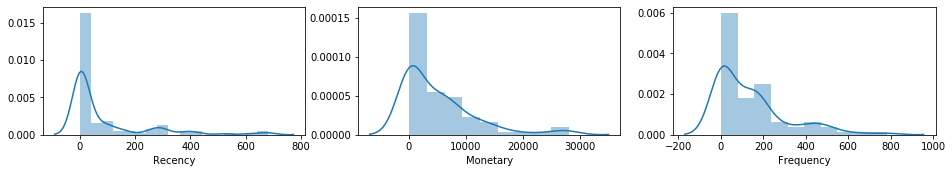

In [34]:
plt.figure(figsize=(16,8))
plt.title('Distrution of RFM Score')
plt.subplot(331); sns.distplot(food_rfm['Recency'])
plt.subplot(332); sns.distplot(food_rfm['Monetary'])
plt.subplot(333); sns.distplot(food_rfm['Frequency'])
plt.show()

* The distribution of RFM score are skewed. 

<h5> Use kmeans to segment customers

In [35]:
#preprocess data to make it central distributed
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
food_rfm_log = np.log(food_rfm+1)
scaler.fit(food_rfm_log)
food_rfm_normalized = scaler.transform(food_rfm_log)

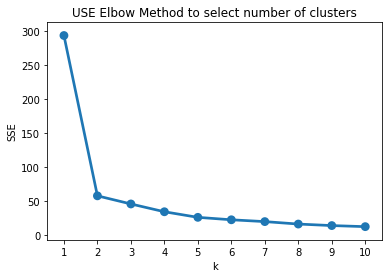

In [36]:
#Figure out best number of clusters
from sklearn.cluster import KMeans
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(food_rfm_normalized)
    sse[k] = kmeans.inertia_ # sum of squared distances to closest cluster cent
    
plt.title('USE Elbow Method to select number of clusters')
plt.xlabel('k'); 
plt.ylabel('SSE') 
sns.pointplot(x=list(sse.keys()), y=list(sse.values())) 
plt.show()

Therefore we seperate these customer into 2,3 clusters

In [89]:
#Implement kmeans algorithm
kmeans = KMeans(n_clusters=2, random_state=1)
kmeans.fit(food_rfm_normalized)
cluster_labels = kmeans.labels_

food_rfm_k2 = food_rfm.assign(Cluster = cluster_labels)

food_rfm_k2.groupby(['Cluster']).agg({ 'Recency': 'mean',
                                          'Frequency': 'mean',
                                          'Monetary': ['mean', 'count'],
}).round(0)

Recency Frequency Monetary      
           mean      mean     mean count
Cluster                                 
0           4.0     236.0   8624.0    57
1         204.0       5.0    125.0    41

In [93]:
#Implement kmeans algorithm
kmeans = KMeans(n_clusters=3, random_state=1)
kmeans.fit(food_rfm_normalized)
cluster_labels = kmeans.labels_

food_rfm_k2 = food_rfm.assign(Cluster = cluster_labels)

result = food_rfm_k2.groupby(['Cluster']).agg({ 'Recency': 'mean',
                                          'Frequency': 'mean',
                                          'Monetary': ['mean', 'count'],
})
result.columns = ['Recency Mean','Frequency Mean', 'Monetary Mean','Count']
result.round(0).reset_index()


,Cluster,Recency Mean,Frequency Mean,Monetary Mean,Count
0,0,4.0,240.0,8773.0,56
1,1,250.0,6.0,131.0,33
2,2,15.0,6.0,117.0,9


* Despite 2 cluster separate customers very well, 3 clusters seems to provide more insight. 
  - i.e.: there exist some customers that not very active but we haven't lost yet, which means we can take action to save them. 

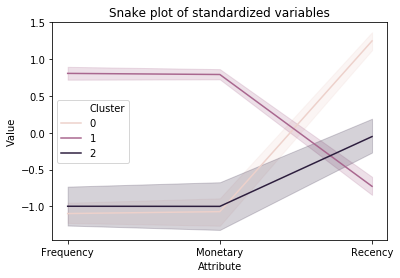

In [66]:
#visulize with snake plot
food_rfm_normalized = pd.DataFrame(food_rfm_normalized, index=food_rfm.index,
columns=food_rfm.columns) 
food_rfm_normalized['Cluster'] = food_rfm_k2['Cluster']
food_melt = pd.melt(food_rfm_normalized.reset_index(), id_vars=['HSHD_NUM', 'Cluster'],
value_vars=['Recency', 'Frequency', 'Monetary'], var_name='Attribute',
value_name='Value')

plt.title('Snake plot of standardized variables') 
sns.lineplot(x="Attribute", y='Value', hue='Cluster', data=food_melt)
plt.show()

Kmeans seperate clustomers successfully. 
 - Cluster 1 is more engaged: 
     - recently has been to the mark; 
     - goes very often;
     - spend a lot 
 - Cluster 0 can be treated as disactive or churned: 
     - it has been a long while since its last visit time;
     - visit few times;
     - spend very less; 
 - Cluster 2 can be treated as lazy: 
     - it has been sometime but not very long since its last visit time;
     - visit few times;
     - spend very less;
     

### 3. Analysis of Demographic Factors

Now I tried to analyze the demographic factors that might affect customer engagement

In [67]:
hshd = pd.merge(household,food_rfm_k2,how='inner',left_on='HSHD_NUM',right_index=True)
hshd.dropna(how='any',inplace=True)
hshd.set_index('HSHD_NUM',inplace=True)
grouped = hshd.groupby('Cluster')

In [68]:
hshd['INCOME_RANGE']= hshd['INCOME_RANGE'].replace({'UNDER 35K':"a.UNDER 35K",
                                                    '35-49K':'b.35-49K','50-74K': 'c.50-74K',
                                                   '75-99K':'d.75-99K','100-150K':'e.100-150K',
                                                   '150K+':'g.150K+'})
hshd['CHILDREN'] = hshd['CHILDREN'].replace({'NOT AVAILABLE':'0'})


In [82]:
def pie_plot(grouped,metric):
    engaged= grouped[metric].value_counts()[1]
    engaged= engaged.sort_index()
    disactive = grouped[metric].value_counts()[0]
    disactive = disactive.sort_index()
#     lazy = grouped[metric].value_counts()[2]
#     lazy = lazy.sort_index()
    fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])
    fig.add_trace(go.Pie(labels=engaged.index, values=engaged.values, name="Engaged Customer"),
                  1, 1)
#     fig.add_trace(go.Pie(labels=lazy.index, values=lazy.values, name="Disactive Customer"),
#                   1, 2)
    fig.add_trace(go.Pie(labels=disactive.index, values=disactive.values, name="Disactive Customer"),
                  1, 2)
    # Use `hole` to create a donut-like pie chart
    fig.update_traces(hole=.4, hoverinfo="label+percent+name+value",textinfo='label+percent')
    
    fig.update_layout(
        title_text=f"Pie plot of {metric}",
        # Add annotations in the center of the donut pies.
        annotations=[dict(text='Engaged Customer', x=0.18, y=0.5, font_size=15, showarrow=False),
#                      dict(text='Lazy Customer', x=0.56, y=0.5, font_size=15, showarrow=False),
                     dict(text='Disactive Customer', x=0.82, y=0.5, font_size=15, showarrow=False)]
        )
    fig.show()
def bar_plot(grouped,metric,seperate=False):
    engaged= grouped[metric].value_counts()[1]
    engaged= engaged.sort_index()
    disactive = grouped[metric].value_counts()[0]
    disactive = disactive.sort_index()
#     lazy = grouped[metric].value_counts()[2]
#     lazy = lazy.sort_index()
    if seperate==True:
        fig = make_subplots(rows=1,cols=2)
        fig.add_trace(go.Bar(x=engaged.index,y=engaged.values, name="Engaged Customer")
               ,1,1   )
        fig.add_trace(go.Bar(x=disactive.index, y=disactive.values, name="Disactive Customer")
               ,1,2)
 
    else:
        fig = go.Figure()
        fig.add_trace(go.Bar(x=engaged.index,y=engaged.values, name="Engaged Customer")
                  )
#         fig.add_trace(go.Bar(x=lazy.index, y=lazy.values, name="Lazy Customer")
#                  )
        fig.add_trace(go.Bar(x=disactive.index, y=disactive.values, name="Disactive Customer")
                 )
    
    fig.update_layout(
        title_text=f"Bar plot of {metric}")
    fig.show()

Loyalty

In [83]:
pie_plot(grouped,'Loyalty_flag')

* customer with loyalty flag tends be more engaged

 Marriage

In [84]:
pie_plot(grouped,'MARITAL')

* no considerable difference

Household size

In [85]:
bar_plot(grouped,'HH_SIZE',seperate=True)

Household composition

In [86]:
bar_plot(grouped,'HSHD_COMPOSITION')

* single male seems to more engaged

In [87]:
bar_plot(grouped,'AGE_RANGE')

* People age between 55-64 tends to more engaged

In [88]:
bar_plot(grouped,'INCOME_RANGE')

* People with lower income, especially under 35 tends to be more egaged